# Student GLM: Define events
Natalia Vélez, April 2022

In [54]:
%matplotlib inline

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy, spearmanr
from ast import literal_eval
from os.path import join as opj

sys.path.append('..')
from utils import gsearch, str_extract, int_extract

sns.set_style('white')
sns.set_context('talk')

Load student data:

In [2]:
student_df = (
    pd.read_csv('outputs/student_behavior.csv')
    .drop(columns=['order'])
    .rename(columns={'num_hint': 'student_idx'})
)
student_df['bets'] = student_df.bets.apply(literal_eval)
student_df.head()

,time_elapsed,teacher,problem,num_trial,student_idx,bets,bonus,worker,batch
0,181304,sub-04,34.0,0.0,0.0,"[0, 35, 41, 48]",0.013777,ARI1EMAHUA9PO,2022-02-02-1303
1,192911,sub-04,34.0,0.0,1.0,"[0, 50, 49, 0]",0.020623,ARI1EMAHUA9PO,2022-02-02-1303
2,203582,sub-04,34.0,0.0,2.0,"[0, 0, 100, 0]",0.041667,ARI1EMAHUA9PO,2022-02-02-1303
3,223655,sub-27,15.0,1.0,0.0,"[0, 52, 50, 48]",0.014444,ARI1EMAHUA9PO,2022-02-02-1303
4,232054,sub-27,15.0,1.0,1.0,"[0, 52, 50, 0]",0.021242,ARI1EMAHUA9PO,2022-02-02-1303


Find original behavioral data:

In [3]:
data_dir = '/n/gershman_ncf/Lab/natalia_teaching/'
original_files = gsearch(data_dir, 'behavioral', '*.json')
original_files = [f for f in original_files if 'run-practice' not in f] # trim out practice runs
original_files.sort()

print(f'{len(original_files)} behavioral files found')
print(*original_files[:10], sep='\n')
print('...')

299 behavioral files found
/n/gershman_ncf/Lab/natalia_teaching/behavioral/sub-01_task-teaching_run-01_behavioral_1628798255.json
/n/gershman_ncf/Lab/natalia_teaching/behavioral/sub-01_task-teaching_run-02_behavioral_1628798680.json
/n/gershman_ncf/Lab/natalia_teaching/behavioral/sub-01_task-teaching_run-03_behavioral_1628799162.json
/n/gershman_ncf/Lab/natalia_teaching/behavioral/sub-01_task-teaching_run-04_behavioral_1628800012.json
/n/gershman_ncf/Lab/natalia_teaching/behavioral/sub-01_task-teaching_run-05_behavioral_1628800423.json
/n/gershman_ncf/Lab/natalia_teaching/behavioral/sub-01_task-teaching_run-06_behavioral_1628800796.json
/n/gershman_ncf/Lab/natalia_teaching/behavioral/sub-01_task-teaching_run-07_behavioral_1628801177.json
/n/gershman_ncf/Lab/natalia_teaching/behavioral/sub-01_task-teaching_run-08_behavioral_1628801584.json
/n/gershman_ncf/Lab/natalia_teaching/behavioral/sub-01_task-teaching_run-09_behavioral_1628802076.json
/n/gershman_ncf/Lab/natalia_teaching/behaviora

Load teacher data:

In [4]:
teach_df = (
    pd.read_csv('../2_behavioral/outputs/teaching_behavior.csv')
    .rename(columns={'ex_idx': 'num_hint', 'subject': 'teacher', 'rating': 'teacher_rating'})
)

# data clean-up: line up student and teacher trial indices
teach_df['teacher'] = teach_df.teacher.apply(lambda x: f'sub-{x:02}')
teach_df['hint_provided'] = ~pd.isna(teach_df.example)
teach_df['hint_cumsum'] = teach_df.groupby(['teacher', 'problem'])['hint_provided'].cumsum() - 1
teach_df['student_idx'] = np.where(teach_df.hint_provided, teach_df.hint_cumsum, np.nan)

teach_df.head()

,teacher,run,block_idx,num_hint,first_movement,start,onset,problem,order,example,teacher_rating,hint_provided,hint_cumsum,student_idx
0,sub-01,1,0,0,"[0, 1]","[0, 0]",30.00,22,"['C', 'B', 'D', 'A']","[1, 2]",1.0,True,0,0.0
1,sub-01,1,0,1,"[0, 1]","[0, 0]",45.35,22,"['C', 'B', 'D', 'A']","[4, 3]",2.0,True,1,1.0
2,sub-01,1,0,2,"[0, 1]","[0, 0]",59.35,22,"['C', 'B', 'D', 'A']",NaN,2.0,False,1,NaN
3,sub-01,1,1,0,"[0, 4]","[0, 5]",104.05,18,"['D', 'B', 'C', 'A']","[0, 3]",0.0,True,0,0.0
4,sub-01,1,1,1,"[0, 4]","[0, 5]",118.45,18,"['D', 'B', 'C', 'A']","[5, 2]",NaN,True,1,1.0


Get matching indices

In [5]:
matching_indices = (
    teach_df
    [['teacher', 'problem', 'student_idx', 'num_hint']]
    .rename(columns={'num_hint': 'ex_idx'})
)

student_df = (
    student_df
    .merge(matching_indices)
    .sort_values(by=['worker', 'num_trial', 'student_idx'])
    .reset_index(drop=True)
)

Load problem orders:

In [6]:
problem_orders = (
    teach_df
    [['teacher', 'problem', 'run', 'block_idx', 'order']]
    .drop_duplicates()
)
problem_orders['order'] = problem_orders.order.apply(literal_eval)
problem_orders.head()

,teacher,problem,run,block_idx,order
0,sub-01,22,1,0,"[C, B, D, A]"
3,sub-01,18,1,1,"[D, B, C, A]"
6,sub-01,1,1,2,"[A, D, C, B]"
9,sub-01,16,1,3,"[B, C, A, D]"
12,sub-01,20,2,0,"[D, C, A, B]"


## Measure empirical pTrue, KL

Data wrangling:

In [7]:
def sort_bets(row):
    beliefs_sorted = [bet for h, bet in sorted(zip(row.order, row.bets))]
    return beliefs_sorted

# Reorder student bets to align with model-predicted belief distribution:
student_belief = student_df.copy().merge(problem_orders, on =['teacher', 'problem'], how='left')
student_belief['bets_sorted'] = student_belief.apply(sort_bets, axis=1)
student_belief['pTrue'] = student_belief.bets_sorted.apply(lambda b: b[0]/sum(b))
student_belief['num_hint'] = (student_belief['student_idx']+1).astype(int)

# Measure KL divergence
kl_list = []
for name,group in student_belief.groupby(['worker', 'problem']):
    prior = np.ones(4)/4 # start with a uniform prior
    
    for _, row in group.iterrows():
        bets = np.array(row.bets_sorted) + 0.0001 # small adjustment to fix divide-by-0 error
        belief = bets/np.sum(bets)
        kl = entropy(prior, belief)
        
        prior = belief # carry over belief dist from prior trial
        kl_list.append(kl)
        
student_belief['KL'] = kl_list

print(student_belief.shape)
student_belief.tail(25)

(16150, 17)


,time_elapsed,teacher,problem,num_trial,student_idx,bets,bonus,worker,batch,ex_idx,run,block_idx,order,bets_sorted,pTrue,num_hint,KL
16125,1165930,sub-20,12.0,31.0,0.0,"[25, 25, 25, 23]",0.010629,AZNIEFUIVB2H0,2022-02-16-1639,0,8,1,"[B, A, D, C]","[25, 25, 23, 25]",0.255102,1,5.998858
16126,1176602,sub-20,12.0,31.0,1.0,"[13, 55, 13, 23]",0.022035,AZNIEFUIVB2H0,2022-02-16-1639,1,8,1,"[B, A, D, C]","[55, 13, 23, 13]",0.528846,2,2.819624
16127,1182202,sub-20,12.0,31.0,2.0,"[13, 79, 13, 23]",0.025716,AZNIEFUIVB2H0,2022-02-16-1639,2,8,1,"[B, A, D, C]","[79, 13, 23, 13]",0.617188,3,4.003466
16128,1194436,sub-01,25.0,32.0,0.0,"[25, 25, 30, 25]",0.014881,AZNIEFUIVB2H0,2022-02-16-1639,0,7,3,"[B, D, C, A]","[25, 25, 30, 25]",0.238095,1,2.975051
16129,1202023,sub-01,25.0,32.0,1.0,"[25, 25, 30, 27]",0.015771,AZNIEFUIVB2H0,2022-02-16-1639,2,7,3,"[B, D, C, A]","[27, 25, 30, 25]",0.252336,2,2.404362
16130,1214435,sub-23,6.0,33.0,0.0,"[0, 60, 62, 0]",0.020492,AZNIEFUIVB2H0,2022-02-16-1639,0,5,1,"[D, A, C, B]","[60, 0, 62, 0]",0.491803,1,0.000091
16131,1217395,sub-23,6.0,33.0,1.0,"[0, 63, 62, 0]",0.021000,AZNIEFUIVB2H0,2022-02-16-1639,1,5,1,"[D, A, C, B]","[63, 0, 62, 0]",0.504000,2,0.004491
16132,1222898,sub-23,6.0,33.0,2.0,"[0, 76, 62, 0]",0.022947,AZNIEFUIVB2H0,2022-02-16-1639,2,5,1,"[D, A, C, B]","[76, 0, 62, 0]",0.550725,3,0.125465
16133,1245622,sub-19,14.0,34.0,0.0,"[34, 25, 25, 25]",0.012997,AZNIEFUIVB2H0,2022-02-16-1639,0,4,3,"[A, D, C, B]","[34, 25, 25, 25]",0.311927,1,0.067689
16134,1253811,sub-19,14.0,34.0,1.0,"[21, 61, 25, 25]",0.006629,AZNIEFUIVB2H0,2022-02-16-1639,1,4,3,"[A, D, C, B]","[21, 25, 25, 61]",0.159091,2,6.024442


Plot empirical pTrue, KL

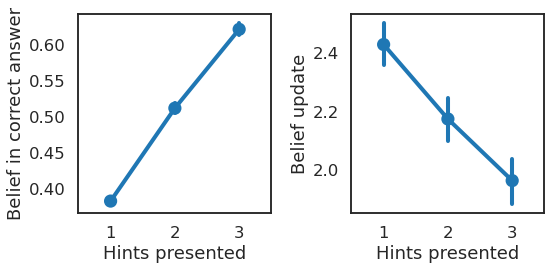

In [8]:
fig,axes = plt.subplots(1,2,figsize=(8,4))

sns.pointplot(data=student_belief, x='num_hint', y='pTrue', ax=axes[0])
axes[0].set(xlabel='Hints presented', ylabel='Belief in correct answer')

sns.pointplot(data=student_belief, x='num_hint', y='KL', ax=axes[1])
axes[1].set(xlabel='Hints presented', ylabel='Belief update')

fig.tight_layout()

Plot correlations between parametric regressors

## Comparison to model-based measures

Load model predictions:

In [9]:
model_df = (
    pd.read_csv('../2_behavioral/outputs/model_regressor_values.csv')
    .melt(id_vars = ['subject', 'problem', 'run', 'block_idx', 'ex_idx'], value_vars=['pTrue', 'KL'])
    .rename(columns={'subject': 'teacher', 'block_idx': 'block_no'})
)
model_df['teacher'] = model_df.teacher.apply(lambda x: f'sub-{x:02}')
model_df['source'] = 'model'
model_df.head()

,teacher,problem,run,block_no,ex_idx,variable,value,source
0,sub-01,22,1,0,0,pTrue,-0.126543,model
1,sub-01,22,1,0,1,pTrue,0.040123,model
2,sub-01,18,1,1,0,pTrue,0.040123,model
3,sub-01,18,1,1,1,pTrue,0.040123,model
4,sub-01,18,1,1,2,pTrue,0.040123,model


Reshape human judgments:

In [10]:
# data-wrangling
human_df = (
    student_belief
    .groupby(['teacher', 'problem', 'run', 'block_idx', 'ex_idx'])
    .agg({'pTrue': 'mean', 'KL': 'mean'})
    .reset_index()
    .melt(id_vars = ['teacher', 'problem', 'run', 'block_idx', 'ex_idx'], value_vars=['pTrue', 'KL'])
)
human_df['problem'] = human_df['problem'].astype(int)
human_df['source'] = 'human'

# mean-center parametric regressors
means = human_df.groupby(['teacher', 'variable']).value.transform('mean')
human_df['value'] = human_df['value'] - means

human_df.head()

,teacher,problem,run,block_idx,ex_idx,variable,value,source
0,sub-01,0,7,2,0,pTrue,-0.022550,human
1,sub-01,0,7,2,1,pTrue,0.118111,human
2,sub-01,0,7,2,2,pTrue,0.329977,human
3,sub-01,1,1,2,0,pTrue,-0.244056,human
4,sub-01,1,1,2,1,pTrue,0.398331,human


Put it all together:

In [11]:
human_vs_model = (
    pd.concat([human_df, model_df])
    .pivot(index=['teacher', 'problem', 'ex_idx', 'variable'], columns='source', values='value')
    .reset_index()
    .dropna(subset=['human', 'model']) 
)
print(human_vs_model.shape)
human_vs_model.head()

(6410, 6)


source,teacher,problem,ex_idx,variable,human,model
0,sub-01,0,0,KL,-0.885856,2.341827
1,sub-01,0,0,pTrue,-0.022550,0.040123
2,sub-01,0,1,KL,-0.200151,-1.223922
3,sub-01,0,1,pTrue,0.118111,0.040123
4,sub-01,0,2,KL,-0.404594,2.687469


Comparison between empirical and model-predicted pTrue:

SpearmanrResult(correlation=0.7803666761407536, pvalue=0.0)


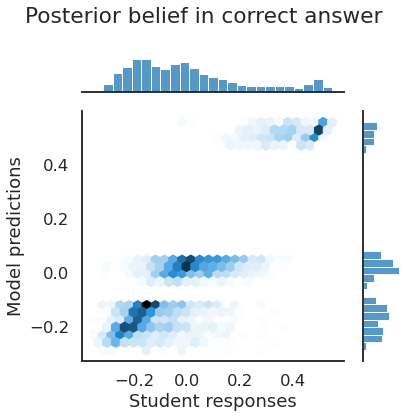

In [27]:
ptrue_df = human_vs_model[human_vs_model.variable == 'pTrue']
print(spearmanr(ptrue_df.human, ptrue_df.model))
g = sns.jointplot(data=ptrue_df, x='human', y='model', kind='hex')
g.fig.suptitle('Posterior belief in correct answer')
g.fig.tight_layout()
g.set_axis_labels('Student responses', 'Model predictions')
plt.savefig('plots/student_vs_model_pTrue.png')

SpearmanrResult(correlation=0.05571119536980578, pvalue=0.0016039776371710333)


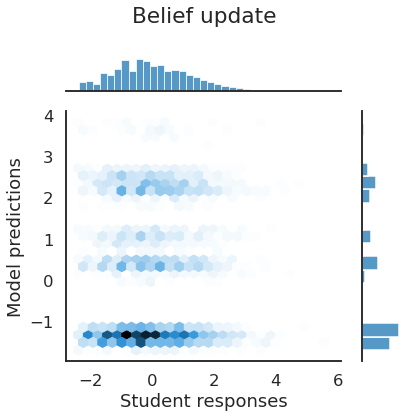

In [29]:
kl_df = human_vs_model[(human_vs_model.variable == 'KL')]
print(spearmanr(kl_df.human, kl_df.model))

g = sns.jointplot(data=kl_df, x='human', y='model', kind='hex')
g.fig.suptitle('Belief update')
g.fig.tight_layout()
g.set_axis_labels('Student responses', 'Model predictions')
plt.savefig('plots/student_vs_model_KL.png')

## Prepare parametric regressors for univariate analyses

Find event files:

In [14]:
data_dir = '../../BIDS_data'
event_files = gsearch(data_dir, 'sub-*', 'func', '*task-teaching*events.tsv')
event_files.sort()

print(f'Found {len(event_files)} behavioral files')
print(*event_files[:10], sep='\n')
print('...')

Found 299 behavioral files
../../BIDS_data/sub-01/func/sub-01_task-teaching_run-01_events.tsv
../../BIDS_data/sub-01/func/sub-01_task-teaching_run-02_events.tsv
../../BIDS_data/sub-01/func/sub-01_task-teaching_run-03_events.tsv
../../BIDS_data/sub-01/func/sub-01_task-teaching_run-04_events.tsv
../../BIDS_data/sub-01/func/sub-01_task-teaching_run-05_events.tsv
../../BIDS_data/sub-01/func/sub-01_task-teaching_run-06_events.tsv
../../BIDS_data/sub-01/func/sub-01_task-teaching_run-07_events.tsv
../../BIDS_data/sub-01/func/sub-01_task-teaching_run-08_events.tsv
../../BIDS_data/sub-01/func/sub-01_task-teaching_run-09_events.tsv
../../BIDS_data/sub-01/func/sub-01_task-teaching_run-10_events.tsv
...


Valid participants:

In [15]:
valid_participants = np.loadtxt('../1_preprocessing/outputs/valid_participants.txt')
valid_participants = ['sub-%02d' % s for s in valid_participants]
print(valid_participants)

['sub-01', 'sub-02', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29', 'sub-30']


Wrangle empirical regressors:

In [16]:
human_reg = (
    human_df
    .rename(columns={'teacher': 'subject', 'block_idx': 'block_no', 'ex_idx': 'trial_no', 'problem': 'stimuli'})
    .sort_values(by=['subject', 'run', 'block_no', 'trial_no'])
    .reset_index(drop=True)
    .drop(columns=['source'])
    .pivot(index=['subject', 'run', 'block_no', 'trial_no', 'stimuli'], columns='variable', values='value')
    .reset_index()
)
print(human_reg.shape)
human_reg.head(10)

(3205, 7)


variable,subject,run,block_no,trial_no,stimuli,KL,pTrue
0,sub-01,1,0,0,22,0.754749,-0.211405
1,sub-01,1,0,1,22,0.248322,-0.069094
2,sub-01,1,1,0,18,1.273673,-0.122948
3,sub-01,1,1,1,18,-2.006561,-0.158416
4,sub-01,1,1,2,18,1.693224,-0.099848
5,sub-01,1,2,0,1,2.506834,-0.244056
6,sub-01,1,2,1,1,0.434128,0.398331
7,sub-01,1,2,2,1,-1.188491,0.498331
8,sub-01,1,3,1,16,-1.355016,-0.148216
9,sub-01,1,3,2,16,2.745766,-0.165959


Check: Correlations between empirical regressors

In [59]:
corr_list = []
for sub,group in human_reg.groupby('subject'):
    res = spearmanr(group.pTrue, group.KL)
    corr_list.append((sub, res.correlation))
    
corr_df = pd.DataFrame(corr_list, columns=['subject', 'correlation'])
print(corr_df.shape)
print(corr_df.correlation.mean())
corr_df.head()

(28, 2)
-0.004715314213142289


,subject,correlation
0,sub-01,0.092732
1,sub-02,0.022082
2,sub-04,0.248490
3,sub-05,-0.022482
4,sub-06,-0.176109


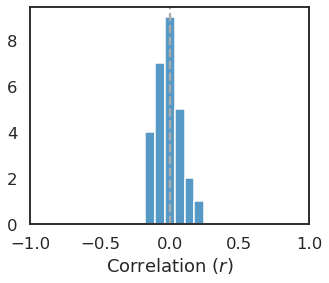

In [58]:
fig,ax=plt.subplots(figsize=(5,4))
sns.histplot(data=corr_df,x='correlation',ax=ax)
ax.set(xlim=(-1,1), xlabel=r'Correlation ($r$)', ylabel='')
ax.axvline(x=0, linestyle='--', color='#aaa')

In [42]:
spearmanr(group.pTrue, group.KL)

SpearmanrResult(correlation=-0.066380301208212, pvalue=0.47131341581792197)

Helper function: Prepare event files

In [17]:
def make_empirical_reg(f):
    
    # get event data
    event_df = pd.read_csv(f, sep='\t')

    # get regressors
    sub = str_extract('sub-[0-9]{2}', f)
    run = int_extract('(?<=run-)[0-9]{2}', f)
    run_reg = human_reg[(human_reg.subject == sub) & (human_reg.run == run)]
    run_reg = run_reg[['block_no', 'trial_no', 'pTrue', 'KL']]

    # split "show" trials based on whether a hint was ever actually presented to students
    choose_trials = event_df[event_df.trial_type == 'choose'].merge(run_reg, on=['block_no', 'trial_no'], how='left')
    missed_trial = pd.isnull(choose_trials.response) | pd.isnull(choose_trials.pTrue)
    show_renamed = np.where(missed_trial, 'show_missed', 'show_new')
    event_df.loc[event_df.trial_type == 'show', 'trial_type'] = show_renamed

    # merge with event files
    show_trials = (
        event_df
        [event_df.trial_type == 'show_new']
        .copy()
        .drop(columns='trial_type')
        .merge(run_reg, on=['block_no', 'trial_no'], how='left')
        .melt(id_vars=['onset', 'duration', 'block_no', 'trial_no', 'stimuli', 'stimuli_order', 'response', 'response_time'],
              value_vars=['pTrue', 'KL'], var_name='trial_type', value_name='value')
    )

    # put everything together
    empirical_events = pd.concat([event_df, show_trials])
    empirical_events = (
        empirical_events
        .assign(trial_type=empirical_events.trial_type.astype('category').cat.reorder_categories(event_df.trial_type.unique().tolist() + ['pTrue', 'KL']))
        .sort_values(by=['onset', 'duration', 'trial_type'])
        [['onset', 'duration', 'trial_type', 'block_no', 'trial_no', 'value']]
        .reset_index(drop=True)
    )

    return empirical_events

Main loop: Assemble event files

In [18]:
out_dir = '../../BIDS_data/derivatives/model_events'
os.makedirs(out_dir, exist_ok=True)

for f in event_files:
    sub = str_extract('sub-[0-9]{2}', f)
    run = str_extract('run-[0-9]{2}', f)
    out_f = opj(out_dir, sub, 'func', f'{sub}_task-teaching_{run}_model-empirical_events.tsv')
    
    if sub in valid_participants:
        print(f'Loading file: {f}')
        out_df = make_empirical_reg(f)
        
        print(f'Saving to: {out_f}\n')
        os.makedirs(opj(out_dir, sub, 'func'), exist_ok=True)
        out_df.to_csv(out_f, sep='\t', index=False, na_rep='n/a')

Loading file: ../../BIDS_data/sub-01/func/sub-01_task-teaching_run-01_events.tsv
Saving to: ../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-01_model-empirical_events.tsv

Loading file: ../../BIDS_data/sub-01/func/sub-01_task-teaching_run-02_events.tsv
Saving to: ../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-02_model-empirical_events.tsv

Loading file: ../../BIDS_data/sub-01/func/sub-01_task-teaching_run-03_events.tsv
Saving to: ../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-03_model-empirical_events.tsv

Loading file: ../../BIDS_data/sub-01/func/sub-01_task-teaching_run-04_events.tsv
Saving to: ../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-04_model-empirical_events.tsv

Loading file: ../../BIDS_data/sub-01/func/sub-01_task-teaching_run-05_events.tsv
Saving to: ../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-05_model-empirical_events.